<a href="https://colab.research.google.com/github/ZeroLeon/NLP_Project_with_FastAI/blob/master/Classical_Chinese_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Language Model of Classical Chinese from Scratch

## Load Data

![替代文字](https://avatars3.githubusercontent.com/u/30764933?s=200&v=4)

Chinese Poetry Dataset   [link](https://github.com/chinese-poetry/chinese-poetry)

中华古诗词数据库, 唐宋两朝近一万四千古诗人, 接近5.5万首唐诗加26万宋诗. 两宋时期1564位词人，21050首词

In [0]:
import os 
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive/fastai'
path = Path(base_dir +'/data/classical_chinese')
path.mkdir(parents=True,exist_ok=True)
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#%%capture
#!pip install plotly==4.0.0
#import plotly.express as px
from fastai.text import *
from fastai.callbacks import *

In [0]:
pwd

'/content/gdrive/My Drive/fastai/data/classical_chinese'

In [0]:
int_list = list(range(0,22000,1000))

In [0]:
!pip install wget
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=0272493a8eed402d633b3ca0ff21187664c2b01e7b2ea521d07f868f4aa84002
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:

for int in int_list:
  wget.download(f'https://raw.githubusercontent.com/chinese-poetry/chinese-poetry/master/ci/ci.song.{int}.json')

In [0]:
df_list = [pd.read_json(f'ci.song.{int}.json') for int in int_list]

In [0]:
df_a = pd.concat(df_list,ignore_index=True,sort=True)

In [0]:
df_a.shape

(21050, 5)

In [0]:
df_a.head(3)

,author,paragraphs,prologue,rhythmic,tags
0,和岘,"[气和玉烛，睿化著鸿明。, 缇管一阳生。, 郊盛礼燔柴毕，旋轸凤凰城。, 森罗仪卫振华缨。,...",NaN,导引,NaN
1,和岘,"[严夜警，铜莲漏迟迟。, 清禁肃，森陛戟，羽卫俨皇闱。, 角声励，钲鼓攸宜。, 金管成雅奏，...",NaN,六州,NaN
2,和岘,"[承宝运，驯致隆平。, 鸿庆被寰瀛。, 时清俗阜，治定功成。, 遐迩咏由庚。, 严郊祀，文物...",NaN,十二时・忆少年,NaN


In [0]:
df_a['txt']=df_a.paragraphs.apply(''.join)

In [0]:
df_a.txt.sample(2)

2304     黄道雨初乾。霁霭空蟠。东风杨柳碧毵毵。燕子不归花有恨，小院春寒。倦客亦何堪。尘满征衫。明朝野...
20050    绿暗汀洲三月暮，落花风静帆收。垂杨低映木兰舟。半篙春水滑，一段夕阳愁。灞水桥东回首处，美人亲...
Name: txt, dtype: object

Not entirely natural language, so need a pretrained model from scratch

## Using sentencepiece as tokenizer

The advantage of SentencePiece:

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 42.0MB/s 


In [0]:
data = (TextList.from_df(df_a,cols=['txt'],processor=SPProcessor(max_vocab_sz=10000,char_coverage=0.98))
        .split_by_rand_pct(0.2,seed=42)
        .label_for_lm()
        .databunch(bs=16,num_workers=1))

In [0]:
len(data.vocab.itos),len(data.train_ds)

(4240, 16840)

In [0]:
data.save('clasChinese_databunch')

In [0]:
data = load_data('.','clasChinese_databunch', bs=16)

In [0]:
data.show_batch(5)

idx,text
0,"海 澄 清 。 道 高 尧 舜 垂 衣 治 , 日月 并 文 明 。 嘉 <unk> 甘 露 登 歌 荐 , 云 物 <unk> 祥 经 。 <unk> 持 <unk> 德 , 未许 禅 云 亭 。 ▁xxbos ▁ 严 夜 <unk> , 铜 莲 漏 迟迟 。 清 禁 肃 , 森 <unk> 戟 , 羽 卫 <unk> 皇 闱 。 角声 <unk> , <unk>"
1,"峨 。 百年 强 半 , 来 日 苦 无多 。 坐 见 黄 州 再 <unk> , 儿童 尽 、 楚 语 吴 歌 。 山中 友 , 鸡 <unk> 社 酒 , 相 劝 老 东 坡 。 云 何 。 当 此去 , 人生 底事 , 来往 如 梭 。 待 闲 看 , 秋风 洛 水 清 波 。 好在 堂前 细 柳 , 应念 我"
2,"雨 收 。 长 波 千 万里 , 拍 天 流 。 云 帆 烟 棹 去 悠悠 。 西风 里 , 归 兴 满 沧 州 。 谩 道 醉 忘 忧 。 荡 高 怀 远 恨 , 更 悲秋 。 一 眉 山色 为谁 愁 。 黄昏 也 , 独自 倚 危楼 。 ▁xxbos ▁ 度 陇 信 音 谁与 寄 。 肠断 江南 千里 。 深"
3,", 风 翻 旗 尾 , 潮 溅 乌 纱 。 今宵 正 对 初 弦 月 , 傍 水 驿 , 深 舣 蒹 葭 。 沈 恨 处 , 时时 自 <unk> 灯 花 。 ▁xxbos ▁ 条 风 布 暖 , 霏 雾 弄 晴 , 池塘 遍 满 春色 。 正是 夜 堂 无 月 , 沈沈 暗 寒食 。 梁 间 燕 , 前 社"
4,"绪 却 成 羞 。 天意 若 教 花 似 雪 , 客 情 宁 恨 鬓 如 秋 。 趁 他 何 <unk> 在 扬州 。 ▁xxbos ▁ 无限 春 情 不肯 休 。 江梅 未 动 使 人 愁 。 东 昏 觑 得 玉 奴 羞 。 对酒 情怀 疑是 梦 , 忆 花 天气 黯 如 秋 。 唤 春 云 梦 泽 南州 。 ▁xxbos"


In [0]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.1, wd=0.1, pretrained=False).to_fp16()

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


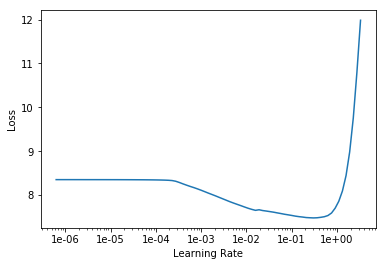

In [0]:
learner.recorder.plot()

In [0]:
lr = 3e-3

In [0]:
learner.unfreeze()
learner.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.658759,5.630425,0.215179,01:00


In [0]:
learner.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.334357,5.299023,0.224823,01:00
1,5.060668,5.096434,0.234658,00:59


relatively low acc:
* More epochs
* Small vocab
* Ancinent words are much more abstract, which causes information loss.This makes it hard to predict next word in classical Chinese.

## Generating some text

In [0]:
text = "雨 收 。 长 波 千 万里 , 拍 天 流"

In [0]:
#Lowering temperature will make the texts less randomized
learner.predict(text, 3, temperature=0.9)

'雨 收 。 长 波 千 万里 , 拍 天 流 枝 冷 暑'

Borrowed codes from [Sing4Me](https://mc.ai/sing4me%E2%80%8A-%E2%80%8Amusic-lyric-generation-with-fastai/)

In [0]:
def generate_txt(word='', temp_init=1, decay=50, stops = ['.'], comma_limit=2, words=80):
    seeds = ['雨', '风', '天', '流']
    word = random.choice(seeds)
    again = []
    stops.append('xxbos')
    last_4 = ['','','','']
    total = []
    stops.append('xxbos')
    i = 0
    commas = 0
    temp = temp_init
    while True:
        if any(x in word for x in stops):
            break
        if commas > comma_limit:
            break    
        if all(x in (" ".join([i for i in word.split()[-9:-5]])) for x in last_4) and (len(word.split()) > 10):
            break
        addition = learner.predict(word, 1, temperature=temp)
        total.append(addition)
        commas = addition.count(',')
        last_4 = total[i].split()[-4:]
        word = addition
        i += 1
        temp = max(abs((math.cos(i * math.pi / decay)))*temp_init,0.1)

#below is the retokenization of the words
    words = total[-2].split()
    for i, word in enumerate(words):
        if word == 'xxbos':
            words[i] = '<br/>'
        elif word == 'xxmaj':
            words[i+1] = words[i+1][0].upper() + words[i+1][1:]
            words[i] = ''
        elif word == 'xxup':
            words[i+1] = words[i+1].upper()
            words[i] = ''     
        elif word == '<unk>' or word == '(' or word == ')' or word == '"'or word == '▁'or word == '▁xxrep':
            words[i] = ''   
        elif word == "n't":
            words[i-1]+= words[i]
            words[i] = ''
        elif word == ",":
            words[i-1]+= words[i]
            words[i] = ''
        elif word == '.' or word == '?' or word == '!' or word == ';':
            words[i-1]+= words[i]
            words[i] = ''
        elif word[0] == "'":
            words[i-1]+= words[i]
            words[i] = ''
        elif word == ' ':
            words[i] = ''
        elif "n't" in word:
            words[i-1]+= words[i]
            words[i] = ''
        elif word == "na":
            words[i-1]+= words[i]
            words[i] = ''
        try:
            words.remove('')
        except:
            continue
            
    return(' '.join(words))


In [0]:
generate_txt()

'风 入 春山 。 正 几 西 娥 临水 。 渐 霜 初 开 。 烟 日 初 浓 寒 晴 日 霁 。 ▁ ▁'